### Simple explaination

If you want to test the AI, run everything before the **training** part, and after it.

If you want to train a new AI from the ground up, run everything before the **test** part.


In [1]:
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
import keras.preprocessing
import keras.datasets.cifar100
import os, gc

from keras import mixed_precision
mixed_precision.set_global_policy(mixed_precision.Policy("mixed_float16"))

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
K.clear_session()
gc.collect()

0

In [4]:
opt = Adam(learning_rate=2.5e-4)

# Google deepdream
## GoogLeNet


In [5]:
class InceptionLayer(Layer):
    def __init__(self, conv_3_3_filters, conv_3_3_reduce_filters,
        conv_5_5_filters, conv_5_5_reduce_filters,
        conv_1_1_filters, conv_pool_projection_filters):
        super().__init__()
        
        self._3_3_conv = Conv2D(
            filters=conv_3_3_filters,
            strides=1,
            kernel_size=3,
            padding="same",
            activation="relu"
        )
        self._3_3_reduce_conv = Conv2D(
            filters=conv_3_3_reduce_filters,
            strides=1,
            kernel_size=1,
            padding="same",
            activation="relu"
        )
        self._5_5_conv = Conv2D(
            filters=conv_5_5_filters,
            strides=1,
            kernel_size=5,
            padding="same",
            activation="relu"
        )
        self._5_5_reduce_conv = Conv2D(
            filters=conv_5_5_reduce_filters,
            strides=1,
            kernel_size=1,
            padding="same",
            activation="relu"
        )
        self._1_1_conv = Conv2D(
            filters=conv_1_1_filters,
            strides=1,
            kernel_size=1,
            padding="same",
            activation="relu"
        )
        self.pool_projection_pool = MaxPool2D(
            pool_size=3,
            strides=1,
            padding="same"
        )
        self.pool_projection_conv = Conv2D(
            filters=conv_pool_projection_filters,
            strides=1,
            kernel_size=1,
            padding="same",
            activation="relu"
        )
        self.concat = Concatenate(axis=-1)

    def call(self, input):
        pool_proj = self.pool_projection_conv(self.pool_projection_pool(input))
        _3_3 = self._3_3_conv(self._3_3_reduce_conv(input))
        _5_5 = self._5_5_conv(self._5_5_reduce_conv(input))
        _1_1 = self._1_1_conv(input)
        return self.concat([_1_1, _3_3, _5_5, pool_proj])

In [6]:
input_layer = Input(shape=(224, 224, 3))
x = Conv2D(filters=64, strides=2, kernel_size=7, padding="same", activation="relu")(input_layer)
x = MaxPool2D(strides=2, pool_size=3, padding="same")(x)
x = Conv2D(filters=64, strides=1, kernel_size=1, padding="valid", activation="relu")(x)
x = Conv2D(filters=192, strides=1, kernel_size=3, padding="same", activation="relu")(x)
x = MaxPool2D(strides=2, pool_size=3, padding="same")(x)
x = InceptionLayer(128, 96, 32, 16, 64, 32)(x)
x = InceptionLayer(192, 128, 96, 32, 128, 64)(x)
x = MaxPool2D(pool_size=3, strides=2, padding="same")(x)
x = InceptionLayer(208, 96,  48,  16, 192,  64)(x)
x = InceptionLayer(224, 112, 64,  24, 160,  64)(x)
x = InceptionLayer(256, 128, 64,  24, 128,  64)(x)
x = InceptionLayer(288, 144, 64,  32, 112,  64)(x)
x = InceptionLayer(320, 160, 128, 32, 256, 128)(x)
x = MaxPool2D(pool_size=3, strides=2, padding="same")(x)
x = InceptionLayer(320, 160, 128, 32, 256, 128)(x)
x = InceptionLayer(384, 192, 128, 48, 384, 128)(x)
x = AveragePooling2D(pool_size=7, strides=1, padding="valid")(x)
x = Flatten()(x)
x = Dropout(rate=.4)(x)
x = Dense(units=1000, activation="softmax")(x)
model = Model(input_layer, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        4160      
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 192)       110784    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 192)      0         
 2D)                                                         

In [7]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Training

In [8]:
validation_db = keras.utils.image_dataset_from_directory(
    "D:\\AI\\ILSVRC2012\\val",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    label_mode="categorical"
)

Found 50000 files belonging to 1000 classes.


In [9]:
train_db = keras.utils.image_dataset_from_directory(
    "D:\\AI\\ILSVRC2012\\train",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    label_mode="categorical"
)

Found 1281167 files belonging to 1000 classes.


In [10]:
lr=2e-4
for i in range(3):
    K.clear_session()
    gc.collect()
    K.set_value(model.optimizer.learning_rate, lr)
    model.fit(train_db, epochs = 8)
    lr *= .96

Epoch 1/8
40037/40037 [==============================] - 14378s 359ms/step - loss: 5.4891 - accuracy: 0.0598
Epoch 2/8
40037/40037 [==============================] - 14733s 368ms/step - loss: 3.9075 - accuracy: 0.2099
Epoch 3/8
40037/40037 [==============================] - 14469s 361ms/step - loss: 3.2967 - accuracy: 0.3021
Epoch 4/8
40037/40037 [==============================] - 14438s 361ms/step - loss: 2.9813 - accuracy: 0.3535
Epoch 5/8
40037/40037 [==============================] - 14435s 360ms/step - loss: 2.7965 - accuracy: 0.3858
Epoch 6/8
40037/40037 [==============================] - 14402s 360ms/step - loss: 2.6759 - accuracy: 0.4074
Epoch 7/8
40037/40037 [==============================] - 14422s 360ms/step - loss: 2.5941 - accuracy: 0.4219
Epoch 8/8
40037/40037 [==============================] - 14427s 360ms/step - loss: 2.5349 - accuracy: 0.4331
Epoch 1/8
40037/40037 [==============================] - 14376s 359ms/step - loss: 2.4691 - accuracy: 0.4444
Epoch 2/8
40037/400

KeyboardInterrupt: 

**Note:** 3 itérations est suffisant, peut-être aurait-il fallu plus ?
Mais il m'a fallu 5579 minutes & 21 secondes pour y arriver.

In [11]:
model.evaluate(validation_db)

1563/1563 [==============================] - 627s 395ms/step - loss: 2.4525 - accuracy: 0.4610


[2.4525318145751953, 0.4610399901866913]

In [12]:
model.save_weights('./googlenet')

## The main part

In [14]:
import PIL.Image
import IPython.display as display

In [9]:
model.load_weights('./googlenet')
model.trainable = False

In [23]:
def load_image(path):
    img = PIL.Image.open(path)
    img.thumbnail((224, 224))
    img = np.array(img)
    return img

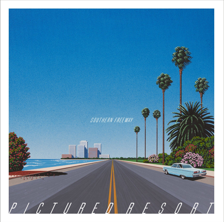

In [24]:
img = load_image('./victim1.jpg')
display.display(PIL.Image.fromarray(np.array(img)))


In [36]:
class DeepDream(tf.Module):
    def __init__(self, classifier):
        super().__init__()
        self.classifier = classifier
    
    def loss(self, img):
        img_batch = tf.expand_dims(img, axis=0)
        layer_activations = self.classifier(img_batch)
        if len(layer_activations) == 1:
            layer_activations = [layer_activations]
        losses = []
        for act in layer_activations:
            loss = tf.math.reduce_mean(act)
            losses.append(loss)

        return tf.reduce_sum(losses)

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32)
        )
    )
    def __call__(self, img, steps, step_size):
        loss = tf.constant(0.)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                tape.watch(img)
                loss = self.loss(img)
                gradients = tape.gradient(loss, img)
                gradients /= tf.math.reduce_std(gradients) + 1e-8
                img += gradients * step_size
                img = tf.clip_by_value(img, 0, 255)
        return loss, img

In [33]:
deepdream = DeepDream(model)

In [34]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    print ("Step {}, loss {}".format(step, loss))
  result = img
  return result


In [37]:
dream_img = run_deep_dream_simple(img=img, steps=100, step_size=0.01)

ValueError: Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[[0.6627451  0.6627451  0.64705884]
  [0.90588236 0.90588236 0.8980392 ]
  [0.8980392  0.8980392  0.8980392 ]
  ...
  [0.8980392  0.8980392  0.8980392 ]
  [0.90588236 0.90588236 0.90588236]
  [0.7647059  0.7647059  0.7490196 ]]

 [[0.7490196  0.7490196  0.73333335]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [0.8666667  0.8666667  0.8509804 ]]

 [[0.7411765  0.7411765  0.7411765 ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [0.85882354 0.85882354 0.84313726]]

 ...

 [[0.7411765  0.7411765  0.7411765 ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [0.85882354 0.85882354 0.84313726]]

 [[0.7411765  0.7411765  0.7411765 ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [0.85882354 0.85882354 0.84313726]]

 [[0.73333335 0.73333335 0.7254902 ]
  [1.         1.         1.        ]
  [0.99215686 0.99215686 0.99215686]
  ...
  [0.99215686 0.99215686 0.99215686]
  [1.         1.         1.        ]
  [0.8509804  0.8509804  0.8352941 ]]], shape=(222, 224, 3), dtype=float32),
    tf.Tensor(100, shape=(), dtype=int32),
    tf.Tensor(0.01, shape=(), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None),
    TensorSpec(shape=(), dtype=tf.int32, name=None),
    TensorSpec(shape=(), dtype=tf.float16, name=None)).

In [ ]:
display.display(PIL.Image.fromarray(np.array(img)))